In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.optimize import curve_fit
#np.set_printoptions(threshold=np.nan)

In [3]:
def import_data(meas_num, path, filename):
    '''import data'''
    filepath = path+'/'+filename+'_'+str(meas_num)+'.dat'
    data = np.loadtxt(filepath)
 
    return data
 
def create_mesh(X,Y,D1,D2=[]):
    # extract sweep values for X
    Xv=np.unique(X)
  
    #Make sure all lines are complete
    no=len(X)%len(Xv)
    X=X[0:(len(X)-no)]
    Y=Y[0:(len(Y)-no)]
    D1=D1[0:(len(D1)-no)]
    if len(D2)!=0:
        D2=D2[0:(len(D2)-no)]
   
    # extract sweep values for Y
    Yv=np.unique(Y)
           
    #Create grids.
    Xm,Ym = np.meshgrid(Xv,Yv)
    D1m=D1.reshape(Xm.shape)
    if len(D2)!=0:
        D2m=D2.reshape(Xm.shape)
   
    # flip if the scan direction is positive to negative
    if Yv[0]==Y[0]:
        Yv=Yv
    elif len(D2)!=0:
        D1m=np.flipud(D1m)
        D2m=np.flipud(D2m)
    else:
        D1m=np.flipud(D1m)
   
    if len(D2)!=0:
        return Xm, Ym, D1m, D2m
    else:
        return Xm, Ym, D1m

In [4]:
def window(d, window_length, window_offset):
    middle= int(len(d)/2)

    start_ind = middle - window_length + window_offset
    end_ind = middle + window_length + window_offset
    return start_ind, end_ind

In [5]:
def calc_Is(bias, signal, cutoff):
    index = 0
    gradHeight = 0
    gradient = np.gradient(signal)
    #gradient = scipy.signal.savgol_filter(np.absolute(np.gradient(signal)),1,0)
    for i in range(0, len(gradient)):
        if gradient[i] > gradHeight:
            index = i
            gradHeight = gradient[i]
    if gradient[index] > cutoff:
        return bias[index], gradient
    else:
        return 0, gradient

In [15]:
def calc_Is2(bias, signal, startIndx, endIndx, thresh1, thresh2):
    fit = np.polyfit(bias[startIndx:endIndx],signal[startIndx:endIndx],1)
    signal = signal - np.poly1d(fit)(bias)
    switch_ind = 0
    trapping_ind = 0
    for i, val in enumerate(signal[:]):
        if val > thresh1 and trapping_ind == 0:
            #print(val, thresh1)
            trapping_ind = i
        if val > thresh2:
            switch_ind = i
            return bias[switch_ind], bias[trapping_ind], signal
            
    #return signal

In [7]:
def extract_Is(x,y,d, trap_thresh, switch_thresh, window_length, window_offset=0):
    switch_currs = []
    trap_currs = []
    yvalues = []
    
    start, end = window(d[0], window_length, window_offset)
    thresh = 1e-6

    for i, linecut in enumerate(d):
        yvalues.append(y[i,0])
        Is, Ir, signal = calc_Is2(x[0],linecut,start,end, trap_thresh, switch_thresh)
        switch_currs.append(Is)
        trap_currs.append(Ir)
    return yvalues, np.array(switch_currs), np.array(trap_currs)

In [8]:
def find_min_max(B_field, switch_currs, trap_currs, window_length, window_offset=0):
    start, end = window(B_field, window_length, window_offset)
    switch_min = np.argmin(switch_currs[start:end])
    trap_max = np.argmax(trap_currs[start:end])
    return start+switch_min, start+trap_max


In [9]:
def find_switch_min(yvalues, switch_currs, trap_currs, fit_window_length, avg_nmbr=4, window_offset=0):
    start, end = window(yvalues, window_length, window_offset)
    
    switch_currs_sort, yvalues_sort = zip(*sorted(zip(switch_currs[start:end], yvalues[start:end])))
    avg_switch = np.average(switch_currs_sort[:avg_nmbr])
    avg_y = np.average(yvalues_sort[:avg_nmbr])
    
    trap_currs_sort, trapy_sort = zip(*sorted(zip(trap_currs[start:end], yvalues[start:end])))
    avg_trap = np.average(trap_currs_sort[-avg_nmbr:])
    avg_trapy = np.average(trapy_sort[-avg_nmbr:])

    #plt.plot(yvalues[start:end], trap_currs[start:end])
    #plt.plot(trapy_sort[-avg_nmbr:], trap_currs_sort[-avg_nmbr:])
    #plt.scatter(avg_trapy, avg_trap)
    #plt.show()
    
    return avg_y, avg_switch, avg_trapy, avg_trap



# plots of data

301
-6.14810472727e-07 -1e-06
22.0 -22.0 -16.904535


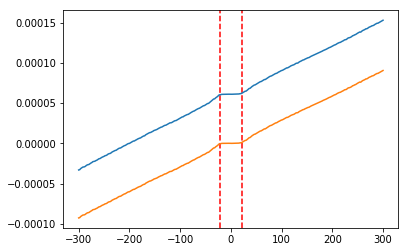

In [10]:
path = "D:/eleerssen/Data/JJ_SQUID_gates_CD3"
filename = "JJ_SQUID_gates_SQUID_6_7_2Vgate_dacmagnet"
filenumber = 6
data_col = 3
lc_nmb=31

data = import_data(filenumber, path, filename)
Xm, Ym, D1m = create_mesh(data[:,0],data[:,1],data[:,data_col])


middle= int(len(D1m[0])/2)
window_length = 5
start = middle - window_length
end = middle + window_length

trap_tresh = -1e-6
switch_tresh = 1e-6
print(len(D1m[lc_nmb]))

'''
for i in range(25, 50):
    Is, Ir, signal = calc_Is2(Xm[0],D1m[i],start,end, trap_tresh, switch_tresh)
    print(Is, Ir, Ym[i,0])
'''

Is, Ir, signal = calc_Is2(Xm[0],D1m[lc_nmb],start,end, trap_tresh, switch_tresh)
print(Is, Ir, Ym[lc_nmb,0])

plt.axvline(x=Is, color='r', ls='--')
plt.axvline(x=Ir, color='r', ls='--')
plt.plot(Xm[0], D1m[lc_nmb])
plt.plot(Xm[0], signal)
plt.show()

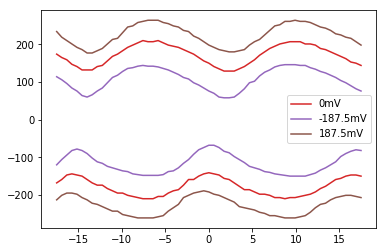

In [16]:
path = "D:/eleerssen/Data/JJ_SQUID_gates_CD3"
filename = "JJ_SQUID_gates_SQUID_6_7_Vgate_dacmagnet"
labels = iter(["0mV", "-187.5mV", "187.5mV"])
data_col = 4
trap_thresh = -1e-6
switch_thresh = 1e-6
window_length = 30

for i in range(3,6):
    data = import_data(i, path, filename)
    Xm, Ym, D1m = create_mesh(data[:,0],data[:,1],data[:,data_col])
    

    yvalues, switch_currs, trap_currs = extract_Is(Xm,Ym,D1m, trap_thresh, switch_thresh, window_length)
    
    #avg = np.average(switch_currs)
    #switch_currs = switch_currs-avg
    
    plt.plot(yvalues, switch_currs, 'C' + str(i), label=next(labels))
    plt.plot(yvalues, trap_currs, 'C' + str(i))
plt.legend()
plt.show()

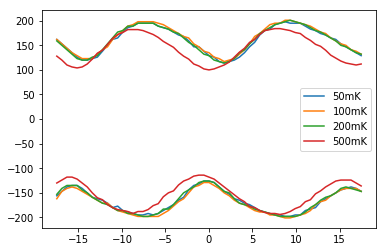

In [17]:
path = "D:/eleerssen/Data/JJ_SQUID_gates_CD3"
filename = "JJ_SQUID_gates_SQUID_6_7_Vgate_dacmagnet_"
temp_ext = ["50mK", "100mK", "200mK", "500mK"]
numbers = iter([2,1,1,1])
labels = iter(["0mV", "-187.5mV", "187.5mV"])
data_col = 4
trap_thresh = -1e-6
switch_thresh = 1e-6
window_length = 30

for i, temp in enumerate(temp_ext):
    file_ext = filename+temp
    
    data = import_data(next(numbers), path, file_ext)
    Xm, Ym, D1m = create_mesh(data[:,0],data[:,1],data[:,data_col])
    

    #yvalues, switch_currs = extract_Is(Xm,Ym,D1m, thresh)
    yvalues, switch_currs, trap_currs = extract_Is(Xm,Ym,D1m, trap_thresh, switch_thresh, window_length)
    
    #avg = np.average(switch_currs)
    #switch_currs = switch_currs-avg
    
    plt.plot(yvalues, switch_currs, 'C' + str(i), label=temp)
    plt.plot(yvalues, trap_currs, 'C' + str(i))
plt.legend()
plt.show()

5.61923076923e-11


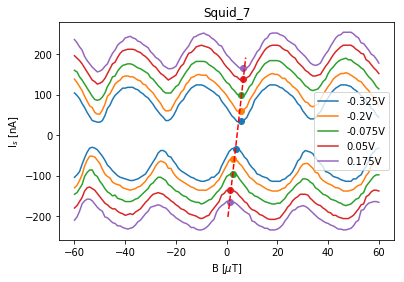

In [18]:
path = "D:/eleerssen/Data/JJ_SQUID_gates_CD3"
filename = "JJ_SQUID_gates_SQUID_6_7_2Vgate_dacmagnet"
labels = iter(["0mV", "-187.5mV", "187.5mV"])
data_col = 4
trap_thresh = -1e-6
switch_thresh = 1e-6
window_length = 10
window_ofs = 0
fit_window_length = 10
colors = iter(range(10))
V_labels = [i/200 for i in range(-240,60,25)]

Imagnet_source=2e-2 
dacmagnet=11.6583/Imagnet_source*1000

B_field = []
currents = []
for i in range(8,13, 1):
    data = import_data(i, path, filename)
    Xm, Ym, D1m = create_mesh(data[:,0],data[:,1],data[:,data_col])
    Xm = Xm*1e-9
    Ym = Ym/dacmagnet
    yvalues, switch_currs, trap_currs = extract_Is(Xm,Ym,D1m, trap_thresh, switch_thresh, window_length)

    '''
    switch_min, trap_max = find_min_max(yvalues, switch_currs, trap_currs, fit_window_length)
    
    B_field.append(yvalues[switch_min])
    B_field.append(yvalues[trap_max])
    currents.append(switch_currs[switch_min])
    currents.append(trap_currs[trap_max])
    '''
    avg_y, avg_switch, avg_trapy, avg_trap = find_switch_min(yvalues, switch_currs, trap_currs, 
                                                             fit_window_length, avg_nmbr=4, window_offset=window_ofs)
    
    B_field.append(avg_y)
    B_field.append(avg_trapy)
    currents.append(avg_switch)
    currents.append(avg_trap)

    color = 'C' + str(next(colors))
    plt.plot(np.array(yvalues)*1e6, np.array(switch_currs)*1e9, color, label=str(V_labels[i-1])+'V')
    #plt.scatter([yvalues[switch_min],yvalues[trap_max]], [switch_currs[switch_min], trap_currs[trap_max]])
    plt.scatter(np.array([avg_y,avg_trapy])*1e6, np.array([avg_switch, avg_trap])*1e9)
    plt.plot(np.array(yvalues)*1e6, np.array(trap_currs)*1e9, color)



currents, B_field = zip(*sorted(zip(currents, B_field)))
fit = np.polyfit(B_field, currents, 1)
print(fit[0]*1e-9)
#print(B_field)
B_field =  [B_field[0] - (B_field[2]-B_field[0])] + list(B_field) + [B_field[-1] +(B_field[-1]-B_field[-3])]
#print(B_field, currents)
plt.plot(np.array(B_field)*1e6, np.poly1d(fit)(B_field)*1e9, ls='--', color='red')
plt.legend()
plt.title("Squid_7")
plt.ylabel("I$_s$ [nA]")
plt.xlabel("B [$\mu$T]")
plt.show()


(5.4999999999999999e-06, 5.4999999999999999e-06, 5.4999999999999999e-06, 6.5000000000000004e-06, 6.5000000000000004e-06)


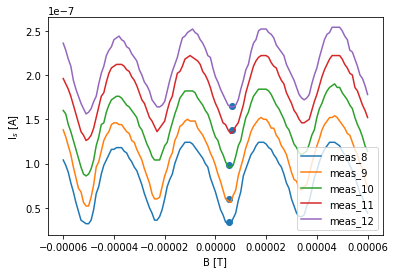

4.80791666667e-07 8.43966942149e-08
4.80791666667e-07 1.11834710744e-07
4.80791666667e-07 1.45669421488e-07
5.68208333333e-07 1.81669421488e-07
5.68208333333e-07 2.10479338843e-07


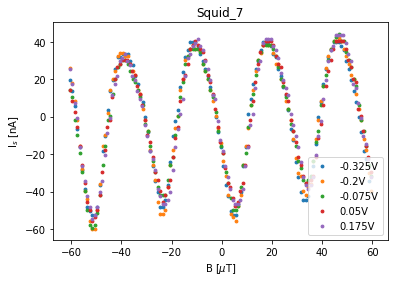

In [19]:
path = "D:/eleerssen/Data/JJ_SQUID_gates_CD3"
filename = "JJ_SQUID_gates_SQUID_6_7_2Vgate_dacmagnet"
labels = iter(["0mV", "-187.5mV", "187.5mV"])
data_col = 4
trap_thresh = -1e-6
switch_thresh = 1e-6
window_length = 10
fit_window_length = 15
colors = iter(range(10))

Imagnet_source=2e-2 
dacmagnet=11.6583/Imagnet_source*1000

V_labels = [i/200 for i in range(-240,60,25)]
B_field = []
currents = []
switch_arr = []
used_meas = []
for i in range(8,13, 1):
    used_meas.append(i)
    data = import_data(i, path, filename)
    Xm, Ym, D1m = create_mesh(data[:,0],data[:,1],data[:,data_col])
    Xm = Xm*1e-9
    Ym = Ym/dacmagnet
    yvalues, switch_currs, trap_currs = extract_Is(Xm,Ym,D1m, trap_thresh, switch_thresh, window_length)

   # switch_min, trap_max = find_min_max(yvalues, switch_currs, trap_currs, fit_window_length)
    avg_b, avg_switch, avg_trapB, avg_trap = find_switch_min(yvalues, switch_currs, trap_currs, fit_window_length)

    #B_field.append(yvalues[switch_min])
    #currents.append(switch_currs[switch_min])

    B_field.append(avg_b)
    currents.append(avg_switch)
    
    switch_arr.append(switch_currs)

    
    color = 'C' + str(next(colors))
    plt.plot(yvalues, switch_currs, color, label='meas_' + str(i))
    #plt.scatter([yvalues[switch_min],yvalues[trap_max]], [switch_currs[switch_min], trap_currs[trap_max]])
    #plt.plot(yvalues, trap_currs, color)



currents, B_field = zip(*sorted(zip(currents, B_field)))
fit = np.polyfit(B_field, currents, 1)

#print(fit[0]*1e-9)
print(B_field)
plt.scatter(B_field, currents)
#plt.plot(B_field, np.poly1d(fit)(B_field), ls='--', color='red')
plt.legend()
plt.ylabel("I$_s$ [A]")
plt.xlabel("B [T]")
plt.show()

for i, trace in enumerate(switch_arr):
    y_offs = np.average(trace)
    x_offs = fit[0]*B_field[i]
    print(x_offs, y_offs)
    plt.scatter((yvalues-x_offs)*1e6, (trace-y_offs)*1e9, label=str(V_labels[used_meas[i]-1])+'V', s=8)

plt.legend()
plt.title("Squid_7")
plt.ylabel("I$_s$ [nA]")
plt.xlabel("B [$\mu$T]")
plt.show() 


In [156]:
def fit_sin1(x, freq, amplitude, phase, offset):
    return np.sin(x*freq +phase)*amplitude + offset

def fit_sin2(x, freq, amplitude, phase, offset, freq2, amplitude2, phase2):
    return np.sin(x*freq2 +phase2)*amplitude2 +np.sin(x*freq +phase)*amplitude + offset

def fit_sin(x, freq, amplitude, phase, offset, freq2, amplitude2, phase2, freq3, amplitude3, phase3):
    return np.sin(x*freq3 +phase3)*amplitude3 + np.sin(x*freq2 +phase2)*amplitude2 +np.sin(x*freq +phase)*amplitude + offset

D:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[199999.99999999997, 6.3382439946830696e-08, 0, -2.0508610228587464e-23, 399999.99999999994, 1.2676487989366139e-08, 0, 399999.99999999994, 1.2676487989366139e-08, 0]
[199999.99999999997, 6.3327147998135789e-08, 0, -7.328410055015254e-24, 399999.99999999994, 1.2665429599627157e-08, 0, 399999.99999999994, 1.2665429599627157e-08, 0]
[199999.99999999997, 5.9254323133556154e-08, 0, -1.1047304709799113e-23, 399999.99999999994, 1.1850864626711232e-08, 0, 399999.99999999994, 1.1850864626711232e-08, 0]
[199999.99999999997, 5.9307846822725313e-08, 0, 1.0719166946141714e-23, 399999.99999999994, 1.1861569364545063e-08, 0, 399999.99999999994, 1.1861569364545063e-08, 0]


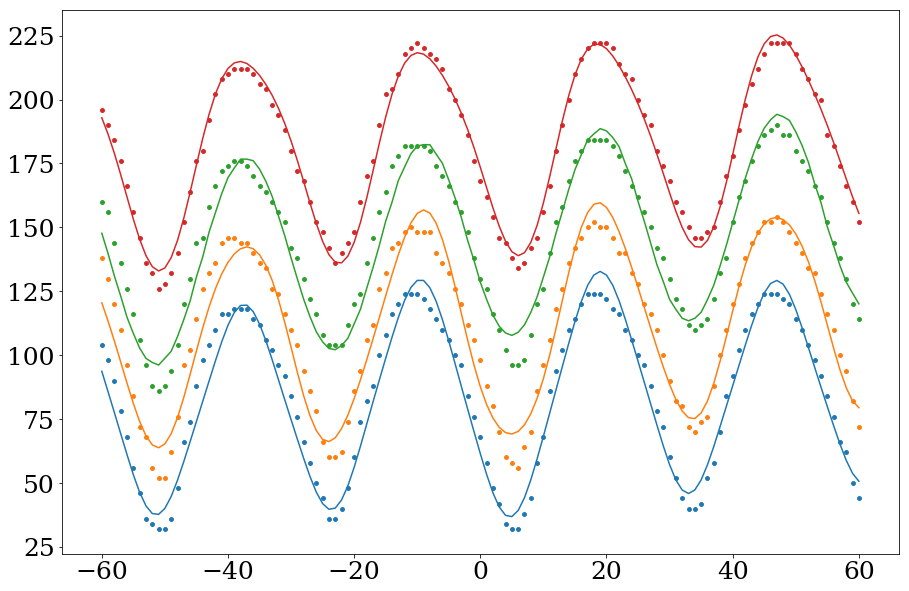

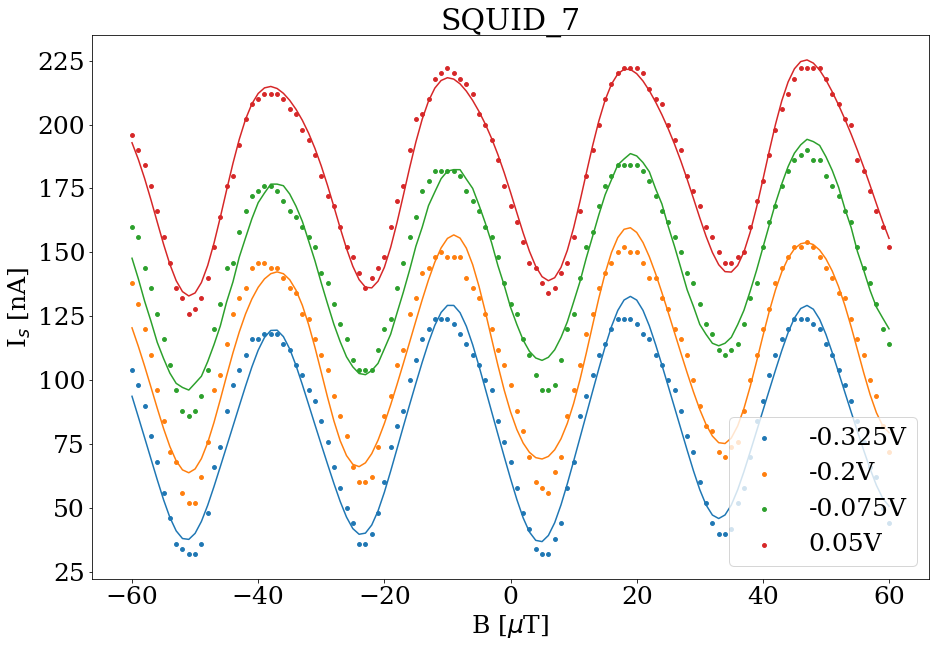

In [162]:
path = "D:/eleerssen/Data/JJ_SQUID_gates_CD3"
filename = "JJ_SQUID_gates_SQUID_6_7_2Vgate_dacmagnet"
labels = iter(["0mV", "-187.5mV", "187.5mV"])
data_col = 4

colors = iter(range(10))

Imagnet_source=2e-2 
dacmagnet=11.6583/Imagnet_source*1000

V_labels = [i/200 for i in range(-240,60,25)]
B_field = []
currents = []
switch_arr = []
used_meas = []

plt.rc('font', family='serif', size=25)
plt.figure(figsize=(15,10))
for i in range(8,12, 1):
    used_meas.append(i)
    data = import_data(i, path, filename)
    Xm, Ym, D1m = create_mesh(data[:,0],data[:,1],data[:,data_col])
    Xm = Xm*1e-9
    Ym = Ym/dacmagnet
    Bfield, switch_currs, trap_currs = extract_Is(Xm,Ym,D1m, trap_thresh, switch_thresh, window_length)
    Bfield = np.array(Bfield)
    
    linefit = np.polyfit(Bfield,switch_currs,1)
    switch_currs = switch_currs - np.poly1d(linefit)(Bfield)
    
    guess_freq = 1/0.5e-5
    guess_amplitude = 3*np.std(switch_currs)/(2**0.5)
    guess_phase = 0
    guess_offset = np.mean(switch_currs)
    
    guess_freq2 = 1/0.25e-5
    guess_amplitude2 = 3*np.std(switch_currs)/(2**0.5)/5
    guess_phase2 = 0
    
    guess_freq3 = 1/0.01e-5
    guess_amplitude3 = 3*np.std(switch_currs)/(2**0.5)/5
    guess_phase3 = 0
    
    #p0=[guess_freq, guess_amplitude, guess_phase, guess_offset]
    p0=[guess_freq, guess_amplitude, guess_phase, guess_offset,
        guess_freq2, guess_amplitude2, guess_phase2,
        guess_freq2, guess_amplitude2, guess_phase2]
    
    fit = curve_fit(fit_sin, Bfield, switch_currs, p0=p0)
    
    data_first_guess = fit_sin(Bfield, *p0)
    data_fit = fit_sin(Bfield, *fit[0])
    print(p0)
    my_color = 'C' + str(next(colors))
    
    plt.scatter(np.array(Bfield)*1e6, (switch_currs+np.poly1d(linefit)(Bfield))*1e9, color=my_color, label=str(V_labels[i-1])+'V', s=15)
    plt.plot(Bfield*1e6, (data_fit+np.poly1d(linefit)(Bfield))*1e9)
    #plt.plot(Bfield*1e6, (data_first_guess+np.poly1d(linefit)(Bfield))*1e9)


plt.legend()
plt.title("SQUID_7")
plt.ylabel("I$_s$ [nA]")
plt.xlabel("B [$\mu$T]")
plt.show()




D:\Anaconda\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


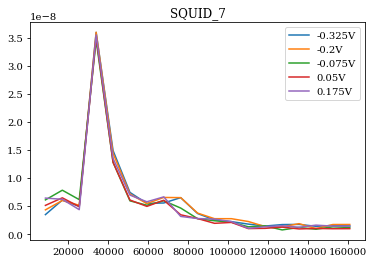

In [137]:
path = "D:/eleerssen/Data/JJ_SQUID_gates_CD3"
filename = "JJ_SQUID_gates_SQUID_6_7_2Vgate_dacmagnet"
labels = iter(["0mV", "-187.5mV", "187.5mV"])
data_col = 4

colors = iter(range(10))

Imagnet_source=2e-2 
dacmagnet=11.6583/Imagnet_source*1000

V_labels = [i/200 for i in range(-240,60,25)]
B_field = []
currents = []
switch_arr = []
used_meas = []

plt.rc('font', family='serif', size=10)
#plt.figure(figsize=(15,10))
for i in range(8,13, 1):
    used_meas.append(i)
    data = import_data(i, path, filename)
    Xm, Ym, D1m = create_mesh(data[:,0],data[:,1],data[:,data_col])
    Xm = Xm*1e-9
    Ym = Ym/dacmagnet

    Bfield, switch_currs, trap_currs = extract_Is(Xm,Ym,D1m, trap_thresh, switch_thresh, window_length)
    Bfield = np.array(Bfield)
    
    #linefit = np.polyfit(Bfield,switch_currs,1)
    #switch_currs = switch_currs - np.poly1d(linefit)(Bfield)
    
    N = len(switch_currs)
    # sample spacing
    T = Bfield[1]-Bfield[0]
    #x = np.linspace(0.0, N*T, N)
    #y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
    yf = scipy.fftpack.fft(switch_currs)
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

    plt.plot(xf[1:20], 2.0/N * np.abs(yf[:N//2])[1:20], label=str(V_labels[i-1])+'V')
    
    #my_color = 'C' + str(next(colors))

    #plt.scatter(np.array(Bfield)*1e6, (switch_currs+np.poly1d(linefit)(Bfield))*1e9, color=my_color, label=str(V_labels[i-1])+'V', s=15)
    #plt.plot(Bfield*1e6, (data_fit+np.poly1d(linefit)(Bfield))*1e9)


plt.legend()
plt.title("SQUID_7")
#plt.ylabel("I$_s$ [nA]")
#plt.xlabel("B [$\mu$T]")
plt.show()



In [119]:
Bfield[1]-Bfield[0]

9.999999999999972e-07